## Import Packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re



## Import Data / Check Nulls

### Load CSV

In [4]:
#Read Kaggle file
df = pd.read_csv("tsa_claims.csv")

#Format columns nicely for dataframe index
df.columns = [s.strip().replace(" ","_") for s in df.columns]

#Rename date columns
df["Date_Received_String"] = df.Date_Received
df["Incident_Date_String"] = df.Incident_Date
df.drop(["Date_Received","Incident_Date"], axis=1, inplace=True)

print(len(df))

204267


/home/perry/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Check Nulls

In [5]:
# Check distribution of nulls per row
temp = df.isnull().sum(axis=1).value_counts().sort_index()
print ("      Rows   Cum. Rows")
for i in range(len(temp)):
    print ("{:2d}: {:7d} {:7d}".format(temp.index[i], temp[i], temp[i:].sum()))

      Rows   Cum. Rows
 0:   94848  204267
 1:   32404  109419
 2:   66106   77015
 3:    4582   10909
 4:    1970    6327
 5:    2253    4357
 6:     977    2104
 7:     321    1127
 8:     634     806
 9:      42     172
10:     106     130
11:      19      24
12:       5       5


In [6]:
# Check distribution of nulls per column
df.isnull().sum().sort_values(ascending=False)

Disposition             72908
Close_Amount            68952
Airline_Name            34374
Airport_Name             8524
Airport_Code             8524
Claim_Type               7913
Claim_Amount             4043
Item                     3966
Incident_Date_String     2183
Claim_Site                740
Date_Received_String      263
Status                      5
Claim_Number                0
dtype: int64

In [7]:
#Drop rows with too many nulls
df.dropna(thresh=6, inplace=True)

#Fill NA for categorical columns
fill_columns = ["Airline_Name","Airport_Name","Airport_Code","Claim_Type","Claim_Site","Item"]
df[fill_columns] = df[fill_columns].fillna("-")

#Set NA Claim Amount to 0. Currently dropping zero values later
df["Claim_Amount"] = df.Claim_Amount.fillna("$0.00")

print(len(df))

#Note: Need to think about how to deal with NA for other columns (or just drop)
#  Disposition / Close amount -> OK, missing data but these are more like dependent vars

#Dropping these nulls later on
#  Incident Date / Date Received
#  Status

203461


## Dependent Variables

### Final Status

In [8]:
df.Status.str.split(";").map(lambda x: "Null" if type(x)==float else x[0]).value_counts()

Denied                                               68336
Approved                                             34997
Deny                                                 28237
Settled                                              27955
-                                                    12752
Approve in Full                                      12364
Canceled                                              6651
Settle                                                5766
Insufficient                                          4972
Closed as a contractor claim                          1312
In litigation                                          108
In review                                                9
Claim has been assigned for further investigation        1
Pending response from claimant                           1
Name: Status, dtype: int64

In [9]:
valid_targets = ['Denied','Approved','Deny','Settled','Approve in Full', 'Settle']

df = df[df.Status.isin(valid_targets)]
df.Status.replace("Approve in Full","Approved",inplace=True)
df.Status.replace("Deny","Denied",inplace=True)
df.Status.replace("Settle","Settled",inplace=True)

print(df.Status.value_counts())
print(len(df))

Denied      96573
Approved    47361
Settled     33721
Name: Status, dtype: int64
177655


### Disposition

In [10]:
df[["Status","Disposition","Claim_Number"]].fillna("NA").groupby(["Status","Disposition"]).count()

Claim_Number
Status   Disposition                  
Approved Approve in Full         34997
         NA                      12364
Denied   Deny                    68296
         NA                      28277
Settled  NA                       5766
         Settle                  27955

## Independent Vars

### Date Received

In [11]:
#Drop nulls
df.dropna(subset=["Date_Received_String"], inplace=True)

#Format datetime
df["Date_Received"] = pd.to_datetime(df.Date_Received_String,format="%d-%b-%y")

#Check year range, create year and month columns
df = df[df.Date_Received.dt.year.isin(range(2002,2014+1))]

print(df.Date_Received.dt.year.value_counts().sort_index())
print(len(df))

#Debug
#temp = df.Date_Received.str.split("-").map(lambda x: x[-1])
#df[temp.map(lambda x: type(x) == float)].sort_values(["Date_Received"])

2002      782
2003    19367
2004    26621
2005    22494
2006    17662
2007    17383
2008    15253
2009    11598
2010     9729
2011     9795
2012     8891
2013     6233
2014     5118
Name: Date_Received, dtype: int64
170926


### Incident Date

In [12]:
month_dict = {"jan":1,"feb":2,"mar":3,"apr":4,"may":5,"jun":6,"jul":7,"aug":8,"sep":9,"oct":10,"nov":11,"dec":12}

def format_dates(regex, date_string):
    '''
    Formats the date string from 2014 entries to be consistent with the rest of the doc 
    Inputs: 
        regex - compiled re with three groups corresponding to {day}/{month (abbrev.)}/{Year}
        date_string - string to be formatted matching the regex
    Outputs: 
        If regex match, return formatted string of form {Month}/{Day}/{Year}; else return original string
    '''
    m = regex.match(date_string)
    if(m):
        day, month, year = m.group(1,2,3)
        return "{}/{}/{}".format(month_dict[month],day,"20"+year)
    else:
        return date_string
        

In [13]:
#Drop nulls
df.dropna(subset=["Incident_Date_String"], inplace=True)

#Error correction for one value in Kaggle data set (looked up in original TSA data)
df.Incident_Date_String.replace("6/30/10","06/30/2010 16:30",inplace=True)

#String formatting for consistency
df["Incident_Date_String"] = df.Incident_Date_String.str.replace("-","/")
df["Incident_Date_String"] = df.Incident_Date_String.str.lower()

#Splitting up time (if exists otherwise will be date) and date components
df["Incident_Time"] = df.Incident_Date_String.str.split(" ").map(lambda x: x[-1])
df["Incident_Date"] = df.Incident_Date_String.str.split(" ").map(lambda x: x[0])

#Could not find a reasonable translation for these entries... most look like "02##"
regex = re.compile(r"/[a-z]{3}/[0-9]{4}")
df = df[df.Incident_Date.map(lambda x: not bool(regex.search(x)))].sort_values(["Date_Received"])

#These are entries received in 2014. Formatting is different from other years but internally consistent.
regex = re.compile(r"(\d*)/([a-z]{3})/(1[1-4])$")
df["Incident_Date"] = df.Incident_Date.map(lambda x: format_dates(regex,x) )
#df[df.Incident_Date.map(lambda x: bool(regex.search(x)))].sort_values(["Date_Received"])

#Format datetime, check year range, create year and month
df["Incident_Date"] = pd.to_datetime(df.Incident_Date,format="%m/%d/%Y")
df = df[df.Incident_Date.dt.year.isin(range(2002,2014+1))]

print(df.Incident_Date.dt.year.value_counts().sort_index())
print(len(df))

2002     1631
2003    21859
2004    26166
2005    21209
2006    17436
2007    17076
2008    14776
2009    10080
2010    10879
2011     9848
2012     8755
2013     5999
2014     4293
Name: Incident_Date, dtype: int64
170007


In [14]:
#Checking cases where Date Received is before Incident date
id_year = (df[df.Date_Received < df.Incident_Date].Incident_Date.dt.year.value_counts().sort_index())
dr_year = (df[df.Date_Received < df.Incident_Date].Date_Received.dt.year.value_counts().sort_index())

print(pd.concat([id_year,dr_year],axis=1),"\n")

print(df[df.Date_Received < df.Incident_Date].Status.value_counts(),"\n")

print((df.Date_Received - df.Incident_Date).value_counts().head(10))

      Incident_Date  Date_Received
2002              2             17
2003             92            110
2004            401            428
2005            298            279
2006            132            121
2007            136            127
2008            136            128
2009             73             68
2010             69             64
2011             50             47 

Denied      750
Approved    351
Settled     288
Name: Status, dtype: int64 

11 days    4823
10 days    4791
12 days    4506
9 days     4448
8 days     4334
15 days    4299
13 days    4252
14 days    4152
16 days    4112
17 days    3975
dtype: int64


### Airport Code / Name

In [15]:
#Look for Mismatched name / code nulls
print(len(df[(df.Airport_Name=="NA") & (df.Airport_Code=="NA")]),
    len(df[(df.Airport_Name!="NA") & (df.Airport_Code=="NA")]),
    len(df[(df.Airport_Name=="NA") & (df.Airport_Code!="NA")]),
    len(df[(df.Airport_Name!="NA") & (df.Airport_Code!="NA")]))

0 0 0 170007


In [16]:
#Duplicates are from excess spaces
df["Airport_Code"] = df.Airport_Code.str.strip()
df["Airport_Name"] = df.Airport_Name.str.strip()

#Check multiple Airport Names assigned to one Airport Code
temp = df.groupby("Airport_Code").Airport_Name.nunique().sort_values(ascending=False)
print(df[df.Airport_Code.isin(temp[temp>1].index)].groupby("Airport_Code").Airport_Name.unique())


Series([], Name: Airport_Name, dtype: float64)


Total: 450 airports, 170007 complaints
Under 1000: 407 airports, 42960 complaints
Under 900: 402 airports, 38199 complaints
Under 800: 397 airports, 34015 complaints
Under 700: 392 airports, 30339 complaints
Under 600: 384 airports, 25052 complaints
Under 500: 378 airports, 21592 complaints
Under 400: 372 airports, 18959 complaints
Under 300: 365 airports, 16513 complaints
Under 200: 348 airports, 12258 complaints
Under 100: 307 airports, 6642 complaints


,Claim_Number,Airport_Code,Airport_Name,Airline_Name,Claim_Type,Claim_Site,Item,Claim_Amount,Status,Close_Amount,Disposition,Date_Received_String,Incident_Date_String,Date_Received,Incident_Time,Incident_Date,Airport_Code_Group,Airport_Name_Group
0,0909802M,EWR,Newark International Airport,Continental Airlines,Property Damage,Checkpoint,Other,$350.00,Approved,$350.00,Approve in Full,4-Jan-02,12/12/2002 0:00,2002-01-04,0:00,2002-12-12,EWR,Newark International Airport
1,0202417M,SEA,Seattle-Tacoma International,-,Property Damage,Checked Baggage,Luggage (all types including footlockers),$100.00,Settled,$50.00,Settle,2-Feb-02,1/16/2004 0:00,2002-02-02,0:00,2004-01-16,SEA,Seattle-Tacoma International
2,0202445M,STL,Lambert St. Louis International,American Airlines,Property Damage,Checked Baggage,Cell Phones,$278.88,Settled,$227.92,Settle,4-Feb-02,11/26/2003 0:00,2002-02-04,0:00,2003-11-26,STL,Lambert St. Louis International
3,0909816M,MIA,Miami International Airport,American Airlines,Property Damage,Checkpoint,Luggage (all types including footlockers),$50.00,Approved,$50.00,Approve in Full,7-Feb-02,1/6/2003 0:00,2002-02-07,0:00,2003-01-06,MIA,Miami International Airport
4,2005032379513,MCO,Orlando International Airport,Delta (Song),Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,$84.79,Approved,$84.79,Approve in Full,18-Feb-02,2/5/2005 0:00,2002-02-18,0:00,2005-02-05,MCO,Orlando International Airport


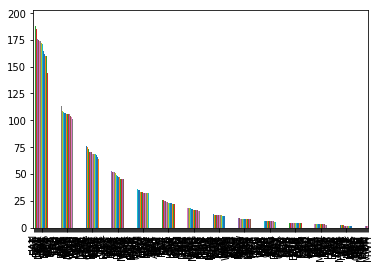

In [17]:
#Look at tail distribution of claims by airport
temp = df.Airport_Code.value_counts()
print("Total: {} airports, {} complaints".format(temp.count(),temp.sum()))
for num in range(1000,1,-100):
    print("Under {}: {} airports, {} complaints".format(num, temp[temp<num].count(),temp[temp<num].sum()))

#This does the same thing since Codes and Names match 1:1    
#temp = df.Airport_Name.value_counts()
#print("Total: {} airports, {} complaints".format(temp.count(),temp.sum()))
#for num in range(1000,1,-100):
#    print("Under {}: {} airports, {} complaints".format(num, temp[temp<num].count(),temp[temp<num].sum()))    
  
#plot distribution below level
level = 200
temp[temp<level].count(), temp[temp<level].sum()
temp[temp<level].plot.bar()

#Set airport and code to "Other" under level
def set_other(row, keep_items):
    if row.Airport_Code in keep_items:
        row["Airport_Code_Group"] = row.Airport_Code
        row["Airport_Name_Group"] = row.Airport_Name
    else:
        row["Airport_Code_Group"] = 'Other'
        row["Airport_Name_Group"] = 'Other'
    return row

keep_set = set(temp[temp>=level].index)
df = df.apply(lambda x: set_other(x,keep_set),axis=1)

df.head(5)

In [18]:
#Look at tail distribution of claims by airport
temp = df.Airport_Code_Group.value_counts()
print("Total: {} airports, {} complaints".format(temp.count(),temp.sum()))
for num in range(1000,1,-100):
    print("Under {}: {} airports, {} complaints".format(num, temp[temp<num].count(),temp[temp<num].sum()))

Total: 103 airports, 170007 complaints
Under 1000: 59 airports, 30702 complaints
Under 900: 54 airports, 25941 complaints
Under 800: 49 airports, 21757 complaints
Under 700: 44 airports, 18081 complaints
Under 600: 36 airports, 12794 complaints
Under 500: 30 airports, 9334 complaints
Under 400: 24 airports, 6701 complaints
Under 300: 17 airports, 4255 complaints
Under 200: 0 airports, 0 complaints
Under 100: 0 airports, 0 complaints


### Airline Name

In [19]:
df["Airline_Name"] = df.Airline_Name.str.strip().str.replace(" ","")
df.Airline_Name.replace("AmericanEagle","AmericanAirlines",inplace=True)
df.Airline_Name.replace("AmericanWest","AmericaWest",inplace=True)
df.Airline_Name.replace("AirTranAirlines(donotuse)","AirTranAirlines",inplace=True)
df.Airline_Name.replace("AeroflotRussianInternational","AeroFlot",inplace=True)
df.Airline_Name.replace("ContinentalExpressInc","ContinentalAirlines",inplace=True)
df.Airline_Name.replace("Delta(Song)","DeltaAirLines",inplace=True)
df.Airline_Name.replace("FrontierAviationInc","FrontierAirlines",inplace=True)
df.Airline_Name.replace("NorthwestInternationalAirwaysLtd","NorthwestAirlines",inplace=True)
df.Airline_Name.replace("SkywestAirlinesAustralia","SkywestAirlinesIncUSA",inplace=True)

df.Airline_Name.value_counts().head(10)
print(len(df))

170007


### Claim Type

In [20]:
df.Claim_Type.value_counts()

Passenger Property Loss    98472
Property Damage            64163
-                           5384
Personal Injury              884
Passenger Theft              429
Employee Loss (MPCECA)       427
Motor Vehicle                238
Complaint                      6
Wrongful Death                 3
Bus Terminal                   1
Name: Claim_Type, dtype: int64

### Claim Site

In [21]:
df.Claim_Site.value_counts()

Checked Baggage    135738
Checkpoint          32628
Other                1037
-                     308
Motor Vehicle         286
Bus Station            10
Name: Claim_Site, dtype: int64

### Item

In [22]:
#Isolating broadest item categories
#Items column is a text list of all item categories. Sub categories are inconsistent across years.
df_item = df.Item.str.split("-").map(lambda x: "" if type(x) == float else x[0])
df_item = df_item.str.split(r" \(").map(lambda x: x[0])
df_item = df_item.str.split(r" &").map(lambda x: x[0])
df_item = df_item.str.split(r"; ").map(lambda x: x[0])
df_item = df_item.str.strip()

categories = df_item.value_counts()

#categories[[not bool(re.compile(";").search(x)) for x in categories.index]][0:]

categories[categories > 100]

Other                               32293
Clothing                            20003
Luggage                             17522
Jewelry                             12923
Cameras                             12781
Computer                            11972
Locks                                9724
Cosmetics                            5941
Baggage/Cases/Purses                 5864
                                     5035
Eyeglasses                           3817
Currency                             3168
Travel Accessories                   2884
Cell Phones                          2376
Personal Electronics                 2127
Sporting Equipment                   1700
Personal Accessories                 1500
DVD/CD Players                       1235
MP3 Players                           967
Medicines                             941
Watches                               864
Alcoholic beverages                   772
Food                                  711
Bags                              

### Claim Amount

count    1.700070e+05
mean     1.766969e+07
std      7.275922e+09
min      0.000000e+00
25%      2.785500e+01
50%      1.169600e+02
75%      3.500000e+02
max      3.000000e+12
Name: Claim_Value, dtype: float64
Denied      92530
Approved    45096
Settled     32381
Name: Status, dtype: int64
170007


Denied      54939
Approved    44095
Settled     28960
Name: Status, dtype: int64

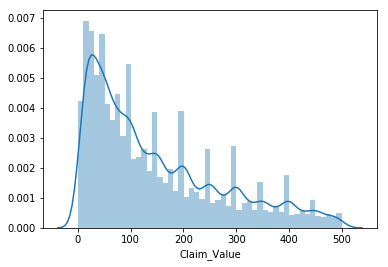

In [23]:
df["Claim_Amount"] = df.Claim_Amount.str.strip()
df["Claim_Amount"] = df.Claim_Amount.str.replace(";","").str.replace("$","")
df["Claim_Value"] = df.Claim_Amount.astype(float)

df_copy = df.copy()

print(df.Claim_Value.describe())
print(df.Status.value_counts())
print(len(df))

sns.distplot(df.Claim_Value[(df.Claim_Value>0)&(df.Claim_Value<500)])

df.Status[(df.Claim_Value>0)&(df.Claim_Value<1000)].value_counts()

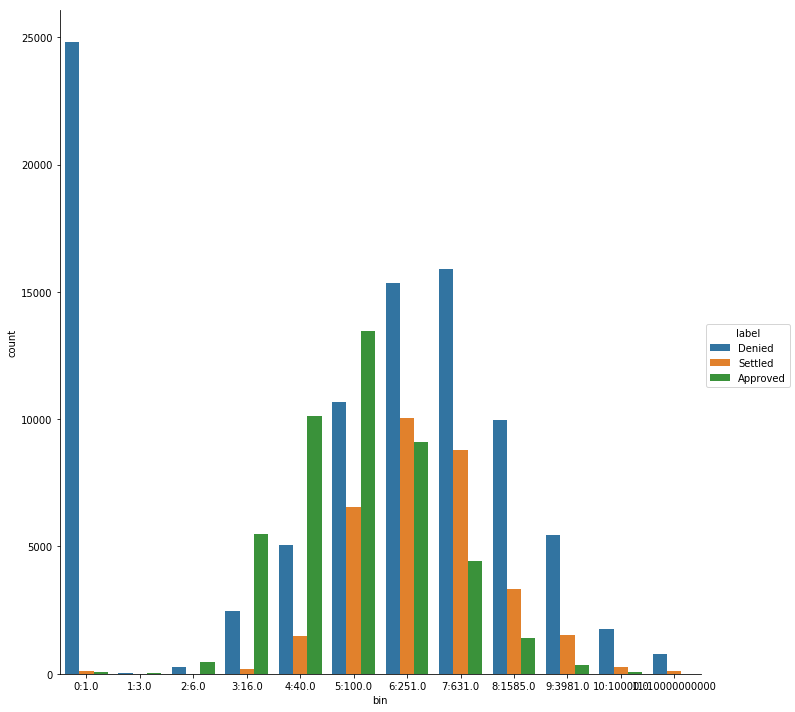

In [24]:
bins = [round(10**x) for x in (list(np.arange(0,4.1,.4))+[10])]
#bins = np.append(np.linspace(1,400,10),np.linspace(1000,10000,5))

bottom = -1

data = []

for x,top in enumerate(bins):
    counts = df.Status[(df.Claim_Value>bottom)&(df.Claim_Value<=top)].value_counts()
    for i in range(len(counts)):
        data.append({"bin":(str(x)+":"+str(top)),"label":counts.index[i],"count":counts[i]})
    bottom = top

counts_df = pd.DataFrame(data)

sns.factorplot(x="bin",y="count",hue="label",data=counts_df,kind="bar",size=10)

In [25]:
df = df[df.Claim_Value != 0]

print(df.Claim_Value.describe())
print(df.Status.value_counts())
print(len(df))

count    1.450120e+05
mean     2.071533e+07
std      7.878063e+09
min      4.800000e-01
25%      5.999750e+01
50%      1.599900e+02
75%      4.226500e+02
max      3.000000e+12
Name: Claim_Value, dtype: float64
Denied      67706
Approved    45021
Settled     32285
Name: Status, dtype: int64
145012


In [26]:
df[df.Claim_Value>10000000]

,Claim_Number,Airport_Code,Airport_Name,Airline_Name,Claim_Type,Claim_Site,Item,Claim_Amount,Status,Close_Amount,Disposition,Date_Received_String,Incident_Date_String,Date_Received,Incident_Time,Incident_Date,Airport_Code_Group,Airport_Name_Group,Claim_Value
13640,0818500M,JFK,John F. Kennedy International,AmericanAirlines,Personal Injury,Checked Baggage,Other,20000000.00,Denied,$0.00,Deny,18-Aug-03,7/14/2003 0:00,2003-08-18,0:00,2003-07-14,JFK,John F. Kennedy International,2.000000e+07
48857,2004122069372,OKC,Will Rogers World,AmericanAirlines,Personal Injury,Checkpoint,-,27225000.00,Denied,$0.00,Deny,2-Nov-04,9/23/2004 0:00,2004-11-02,0:00,2004-09-23,OKC,Will Rogers World,2.722500e+07
50567,2004121669173,-,-,-,Passenger Property Loss,Other,Other,2500000000.00,Denied,$0.00,Deny,23-Nov-04,5/23/2004 0:00,2004-11-23,0:00,2004-05-23,-,-,2.500000e+09
69190,2005080990257,PHX,Phoenix Sky Harbor International,SunCountryAirlinesInc,Personal Injury,Checkpoint,Medicines,125000000.00,Denied,$0.00,Deny,1-Aug-05,6/13/2005 0:00,2005-08-01,0:00,2005-06-13,PHX,Phoenix Sky Harbor International,1.250000e+08
86400,2006060907675,LAX,Los Angeles International Airport,AmericaWest,Personal Injury,Checked Baggage,Currency; Locks; Other,100000000.00,Denied,$0.00,Deny,6-Jun-06,4/19/2006 0:00,2006-06-06,0:00,2006-04-19,LAX,Los Angeles International Airport,1.000000e+08
118207,2008012238289,JFK,John F. Kennedy International,-,Personal Injury,Checkpoint,-,3000000000000.00,Denied,$0.00,Deny,12-Feb-08,12/28/2007 0:00,2008-02-12,0:00,2007-12-28,JFK,John F. Kennedy International,3.000000e+12
124832,2008063046385,OAK,Metropolitan Oakland International,AmericanAirlines,Personal Injury,Checkpoint,-,1000000000.00,Denied,$0.00,Deny,30-Jun-08,4/25/2007 0:00,2008-06-30,0:00,2007-04-25,OAK,Metropolitan Oakland International,1.000000e+09


### Close Amount

In [27]:
df["Close_Amount"] = df.Close_Amount.str.strip()
df["Close_Amount"] = df.Close_Amount.str.replace(";","").str.replace("$","")
df["Close_Value"] = df.Close_Amount.astype(float)
df.Close_Value.describe()

count    128542.000000
mean        101.534805
std         922.714278
min           0.000000
25%           0.000000
50%           0.000000
75%          75.000000
max      250000.000000
Name: Close_Value, dtype: float64

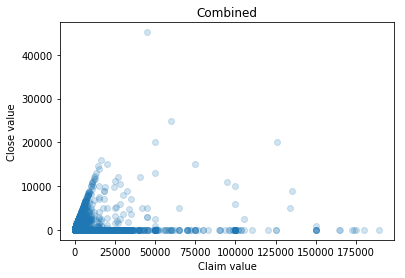

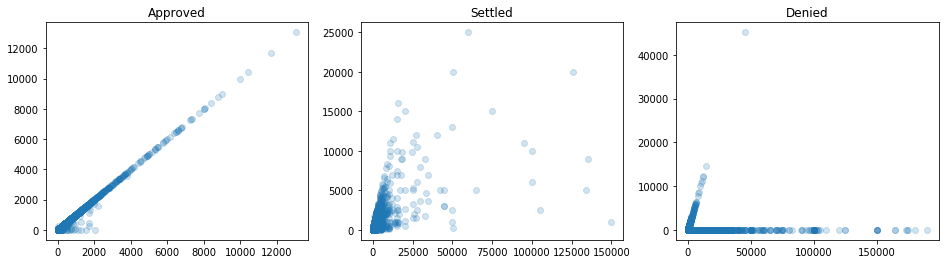

In [28]:
plot_df = df[(df.Claim_Value < 200000) & (df.Close_Value <= 500000)]

plt.scatter(plot_df.Claim_Value,plot_df.Close_Value,alpha=.2)
plt.title("Combined")
plt.xlabel("Claim value")
plt.ylabel("Close value")
plt.show()

fig,ax = plt.subplots(1,3)
fig.set_size_inches(16,4)

for i,s in enumerate(plot_df.Status.unique()):
    ax[i].scatter(plot_df[plot_df.Status==s].Claim_Value,plot_df[plot_df.Status==s].Close_Value,alpha=.2)
    ax[i].set_title(s)


## Export Clean CSV

### Write CSV

In [29]:
output_df = df.drop(["Close_Amount", "Claim_Amount", "Disposition",
                     "Date_Received_String","Incident_Date_String","Incident_Time",
                     "Airport_Code","Airport_Name"],axis=1)

output_df.to_csv("tsa_claims_clean.csv",index=False)

print(len(output_df))

output_df.head(5)

145012


,Claim_Number,Airline_Name,Claim_Type,Claim_Site,Item,Status,Date_Received,Incident_Date,Airport_Code_Group,Airport_Name_Group,Claim_Value,Close_Value
0,0909802M,ContinentalAirlines,Property Damage,Checkpoint,Other,Approved,2002-01-04,2002-12-12,EWR,Newark International Airport,350.00,350.00
1,0202417M,-,Property Damage,Checked Baggage,Luggage (all types including footlockers),Settled,2002-02-02,2004-01-16,SEA,Seattle-Tacoma International,100.00,50.00
2,0202445M,AmericanAirlines,Property Damage,Checked Baggage,Cell Phones,Settled,2002-02-04,2003-11-26,STL,Lambert St. Louis International,278.88,227.92
3,0909816M,AmericanAirlines,Property Damage,Checkpoint,Luggage (all types including footlockers),Approved,2002-02-07,2003-01-06,MIA,Miami International Airport,50.00,50.00
4,2005032379513,DeltaAirLines,Property Damage,Checkpoint,Baby - Strollers; car seats; playpen; etc.,Approved,2002-02-18,2005-02-05,MCO,Orlando International Airport,84.79,84.79


### Count Remaining Nulls

In [30]:
# Check distribution of nulls per row
temp = df.isnull().sum(axis=1).value_counts().sort_index()
for i in range(len(temp)):
    print ("{:2d}: {:7d} {:7d}".format(temp.index[i], temp[i], temp[i:].sum()))

 0:  128533  145012
 1:       9   16479
 2:    1337   16470
 3:   15133   15133


In [31]:
# Check distribution of nulls per column
df.isnull().sum().sort_values(ascending=False)

Close_Value             16470
Close_Amount            16470
Disposition             15142
Airport_Name_Group          0
Claim_Amount                0
Airport_Code                0
Airport_Name                0
Airline_Name                0
Claim_Type                  0
Claim_Site                  0
Item                        0
Status                      0
Airport_Code_Group          0
Claim_Value                 0
Date_Received_String        0
Incident_Date_String        0
Date_Received               0
Incident_Time               0
Incident_Date               0
Claim_Number                0
dtype: int64